In [56]:
%load_ext autoreload

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [57]:
%autoreload 
import pandas as pd
import numpy as np
import h2o
from h2o.automl import H2OAutoML
import utilities as ut

Start h2o client

In [58]:
h2o.init(max_mem_size='16G')

Checking whether there is an H2O instance running at http://localhost:54321. connected.


H2O_cluster_uptime:,1 hour 42 mins
H2O_cluster_timezone:,Europe/Oslo
H2O_data_parsing_timezone:,UTC
H2O_cluster_version:,3.42.0.4
H2O_cluster_version_age:,8 days
H2O_cluster_name:,H2O_from_python_henge_64i7ig
H2O_cluster_total_nodes:,1
H2O_cluster_free_memory:,15.69 Gb
H2O_cluster_total_cores:,8
H2O_cluster_allowed_cores:,8
H2O_cluster_status:,"locked, healthy"


### Load FE data


In [59]:
X_train = pd.read_csv('X_train_selected.csv')
y_train = pd.read_csv('y_train.csv')
X_test = pd.read_csv('X_test_selected.csv')

In [62]:
# set date_foercast as index
X_train.set_index('date_forecast', inplace=True)
y_train.set_index('date_forecast', inplace=True)
X_test.set_index('date_forecast', inplace=True)

In [63]:
X_train_h2o = h2o.H2OFrame(X_train)

Parse progress: |████████████████████████████████████████████████████████████████| (done) 100%


In [72]:
X_test_h2o = h2o.H2OFrame(X_test)

Parse progress: |████████████████████████████████████████████████████████████████| (done) 100%


In [76]:
X_test_h2o

elevation:m,direct_rad:W,diffuse_rad:W,sun_elevation:d,sun_azimuth:d,day_of_year,sfc_pressure:hPa,wind_speed_u_10m:ms,absolute_humidity_2m:gm3,cloud_base_agl:m,day_of_month,ceiling_height_agl:m,visibility:m,year,air_density_2m:kgm3,relative_humidity_1000hPa:p,wind_speed_v_10m:ms,effective_cloud_cover:p,fresh_snow_12h:cm,fresh_snow_3h:cm
6,0,0,-11.185,10.52,121,1013.3,2.2,4.4,1041.2,1,912.7,30210.7,2023,1.286,80.3,3.4,80.7,0,0
7,0,0,-11.184,10.521,121,1013.2,2.2,4.3,1039.9,1,912.3,31329.5,2023,1.283,80.3,3.4,80.7,0,0
24,0,0,-11.223,10.519,121,1010.8,1.5,4.2,1178,1,nan,31411,2023,1.286,81.1,3.1,73.7,0,0
6,0,0,-10.825,14.203,121,1013.2,2.1,4.3,1054.8,1,912.7,30003.6,2023,1.287,80.3,3.4,77,0,0
7,0,0,-10.824,14.204,121,1013,2.1,4.3,1053.1,1,912.3,31181.6,2023,1.283,80.3,3.4,77.1,0,0
24,0,0,-10.862,14.202,121,1010.6,1.5,4.2,1217,1,nan,31295.8,2023,1.286,81,3.1,70.8,0,0
6,0,0,-10.36,17.869,121,1013,2.1,4.3,1068.3,1,912.7,29797.1,2023,1.287,80.3,3.3,73.1,0,0
7,0,0,-10.36,17.87,121,1012.9,2.1,4.3,1066.4,1,912.3,31033.6,2023,1.283,80.2,3.4,73.2,0,0
24,0,0,-10.397,17.868,121,1010.5,1.4,4.1,1256,1,nan,31178.6,2023,1.286,80.9,3.1,67.9,0,0
7,0,0,-9.793,21.514,121,1012.8,2,4.3,1079.6,1,912.3,30885.7,2023,1.283,80.2,3.3,69,0,0


In [64]:
db = pd.concat([X_train, y_train], axis=1)
# remove duplicate columns
db = db.loc[:,~db.columns.duplicated()]

In [65]:
db_h20 = h2o.H2OFrame(db)

Parse progress: |████████████████████████████████████████████████████████████████| (done) 100%


In [66]:
y = "pv_measurement"

x = list(db_h20.columns)
x.remove(y)

In [69]:
db_h20.head()

elevation:m,direct_rad:W,diffuse_rad:W,sun_elevation:d,sun_azimuth:d,day_of_year,sfc_pressure:hPa,wind_speed_u_10m:ms,absolute_humidity_2m:gm3,cloud_base_agl:m,day_of_month,ceiling_height_agl:m,visibility:m,year,air_density_2m:kgm3,relative_humidity_1000hPa:p,wind_speed_v_10m:ms,effective_cloud_cover:p,fresh_snow_12h:cm,fresh_snow_3h:cm,pv_measurement
7,304.3,66.4,23.775,124.573,247,1008.5,-0.3,6.9,2103.1,4,2103.1,45762,2019,1.231,66.1,0.9,0.3,0,0,570.112
6,304.3,66.4,23.775,124.572,247,1008.6,-0.3,6.8,2104,4,2104,48151.2,2019,1.226,66.1,0.9,0.3,0,0,3786.2
24,305.5,66.1,23.796,124.555,247,1005.9,-0.4,6.7,2122.7,4,2122.7,48379.1,2019,1.223,63.5,1.3,0.2,0,0,137.2
7,384.4,73.2,28.732,140.278,247,1007.5,-1.3,6.7,2476.5,4,2476.5,48919.8,2019,1.225,58.8,-0.6,43,0,0,542.512
6,384.4,73.2,28.732,140.277,247,1007.6,-1.3,6.7,2478.4,4,2478.4,51142.4,2019,1.22,58.8,-0.6,43,0,0,3400.76
24,386.7,72.4,28.761,140.26,247,1004.9,-1.2,6.5,2564.5,4,2564.5,51497.8,2019,1.217,55.8,-0.2,41.3,0,0,0
6,413.7,94.5,32.223,157.124,247,1006.5,-2.4,6.2,2733.4,4,2733.4,53565,2019,1.213,51.7,-0.7,46.1,0,0,2620.86
24,415.2,94.5,32.258,157.111,247,1003.8,-2,5.9,2869.8,4,2869.8,53653.4,2019,1.21,49.1,-0.3,46.1,0,0,0
7,413.7,94.5,32.223,157.125,247,1006.4,-2.4,6.3,2731.2,4,2731.2,51362.8,2019,1.219,51.7,-0.7,46.1,0,0,460.575
24,332.4,162.5,33.89,174.827,247,1003.1,-2,5.8,3173.3,4,3173.3,54501.1,2019,1.205,44.2,-0.1,50,0,0,0


## Run AutoML

In [67]:
# %%time
aml = H2OAutoML(max_models=20, max_runtime_secs=12000)
aml.train(x=x, y=y, training_frame=db_h20)

AutoML progress: |█
20:15:22.256: AutoML: XGBoost is not available; skipping it.

██████████████████████████████████████████████████████████████| (done) 100%
CPU times: total: 3.3 s
Wall time: 38min 37s


key,value
Stacking strategy,cross_validation
Number of base models (used / total),5/20
# GBM base models (used / total),4/10
# DRF base models (used / total),1/2
# DeepLearning base models (used / total),0/7
# GLM base models (used / total),0/1
Metalearner algorithm,GLM
Metalearner fold assignment scheme,Random
Metalearner nfolds,5
Metalearner fold_column,None


In [77]:
lb = aml.leaderboard
lb.head(rows=15)

model_id,rmse,mse,mae,rmsle,mean_residual_deviance
StackedEnsemble_AllModels_1_AutoML_3_20231011_201522,230.636,53193.1,80.7729,nan,53193.1
StackedEnsemble_BestOfFamily_1_AutoML_3_20231011_201522,232.944,54262.8,79.806,nan,54262.8
GBM_4_AutoML_3_20231011_201522,233.944,54729.8,80.2868,nan,54729.8
GBM_3_AutoML_3_20231011_201522,238.29,56782,80.9152,nan,56782
GBM_1_AutoML_3_20231011_201522,241.102,58130.4,83.3296,nan,58130.4
GBM_2_AutoML_3_20231011_201522,243.184,59138.4,84.0343,nan,59138.4
DRF_1_AutoML_3_20231011_201522,246.482,60753.2,81.9484,0.956857,60753.2
GBM_5_AutoML_3_20231011_201522,250.65,62825.4,87.6569,nan,62825.4
GBM_grid_1_AutoML_3_20231011_201522_model_2,250.714,62857.8,94.7312,nan,62857.8
GBM_grid_1_AutoML_3_20231011_201522_model_4,251.547,63276.1,94.8363,nan,63276.1


In [78]:
aml.leader #Best model

key,value
Stacking strategy,cross_validation
Number of base models (used / total),5/20
# GBM base models (used / total),4/10
# DRF base models (used / total),1/2
# DeepLearning base models (used / total),0/7
# GLM base models (used / total),0/1
Metalearner algorithm,GLM
Metalearner fold assignment scheme,Random
Metalearner nfolds,5
Metalearner fold_column,None


In [79]:
model = h2o.get_model(aml.leaderboard[0,'model_id'])

In [80]:
pred = model.predict(X_test_h2o)

stackedensemble prediction progress: |███████████████████████████████████████████| (done) 100%


In [81]:
pred.shape

(8640, 1)

In [82]:
pred_pd = pred.as_data_frame()


In [84]:
results = pd.concat([X_test.reset_index(), pred_pd], axis=1)

In [86]:
# convert date_forecast to datetime and set as index
results['date_forecast'] = pd.to_datetime(results['date_forecast'])
results.set_index('date_forecast', inplace=True)

In [92]:
# replace all negative values in predict with 0
results[results < 0] = 0

In [93]:
results.head()

,elevation:m,direct_rad:W,diffuse_rad:W,sun_elevation:d,sun_azimuth:d,day_of_year,sfc_pressure:hPa,wind_speed_u_10m:ms,absolute_humidity_2m:gm3,cloud_base_agl:m,...,ceiling_height_agl:m,visibility:m,year,air_density_2m:kgm3,relative_humidity_1000hPa:p,wind_speed_v_10m:ms,effective_cloud_cover:p,fresh_snow_12h:cm,fresh_snow_3h:cm,predict
date_forecast,,,,,,,,,,,,,,,,,,,,,
2023-05-01 00:00:00,6.0,0.0,0.0,0.0,10.520,121,1013.3,2.2,4.4,1041.2,...,912.7,30210.7,2023,1.286,80.3,3.4,80.7,0.0,0.0,0.000000
2023-05-01 00:00:00,7.0,0.0,0.0,0.0,10.521,121,1013.2,2.2,4.3,1039.9,...,912.3,31329.5,2023,1.283,80.3,3.4,80.7,0.0,0.0,1.578398
2023-05-01 00:00:00,24.0,0.0,0.0,0.0,10.519,121,1010.8,1.5,4.2,1178.0,...,NaN,31411.0,2023,1.286,81.1,3.1,73.7,0.0,0.0,0.000000
2023-05-01 00:15:00,6.0,0.0,0.0,0.0,14.203,121,1013.2,2.1,4.3,1054.8,...,912.7,30003.6,2023,1.287,80.3,3.4,77.0,0.0,0.0,6.661835
2023-05-01 00:15:00,7.0,0.0,0.0,0.0,14.204,121,1013.0,2.1,4.3,1053.1,...,912.3,31181.6,2023,1.283,80.3,3.4,77.1,0.0,0.0,0.432718


<Axes: title={'center': 'H2O AutoML Predictions'}, xlabel='date_forecast'>

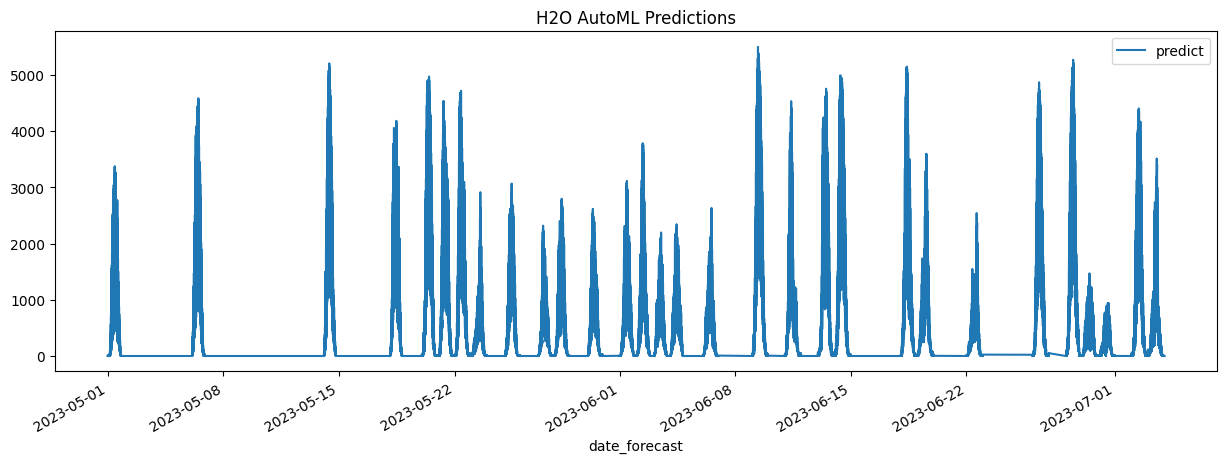

In [94]:

results.plot(y='predict', figsize=(15,5), title='H2O AutoML Predictions')

In [98]:
# rename predict column to pv_prediction
results.rename(columns={'predict': 'pv_prediction'}, inplace=True)
ut.save_to_csv(results, 'H2O_AutoML_Predictions')